### Codes for Figure-1

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pylab as plt
import matplotlib.dates as dt
import matplotlib.ticker as ticker
import numpy as np
import xarray as xr
import cartopy.mpl.ticker as cticker
import matplotlib.patches as patches
from datetime import date, timedelta
import pandas as pd
import marineHeatWaves as mhw
import datetime
plt.rcParams["font.weight"] = "bold"

In [2]:
file = xr.open_dataset("/public/home/songqh/my_data/SST/oisst_1982-2023.nc")
sst_data = file['sst'].loc[file.time.dt.year.isin(np.arange(1982,2023,1)) & file.time.dt.month.isin(7),0:90,100:220]
sst_2022 = file['sst'].loc[file.time.dt.year.isin(2022) & file.time.dt.month.isin(7),0:90,100:220].mean('time')

# sst_mean = sst_data.mean('time')
# np.save("/public/home/songqh/my_data/project/MHW_2022/SST_allyears_mean/sst_mean",sst_mean)
lon = file['lon'].loc[100:220].values
lat = file['lat'].loc[0:90].values
sst_ano = sst_2022 - np.load("/public/home/songqh/my_data/project/MHW_2022/SST_allyears_mean/sst_mean.npy")

In [3]:
file_1 = xr.open_dataset("/public/home/songqh/my_data/SST/oisst_1982-2023_monmean.nc")
sst_oswbs =file_1['sst'].loc[file_1.time.dt.year.isin(np.arange(1982,2023,1)),50:60,140:175].mean(('lon','lat'))
sst_oswbs_mon = sst_oswbs.groupby('time.month').mean(dim='time')
sst_oswbs = sst_oswbs.values.reshape(41,12)
sst_oswbs_ano = np.zeros((41,12))
for y in range(41):
    for m in range(12):
        sst_oswbs_ano[y,m] = sst_oswbs[y,m] - sst_oswbs_mon[m]
sst_oswbs_ano = sst_oswbs_ano.reshape(492)


In [4]:
start_date = np.datetime64('1982-01')
end_date = np.datetime64('2023-01')
num_months = np.arange(np.datetime64(start_date, 'M'), np.datetime64(end_date, 'M'))
datetime_array = list(num_months.astype('datetime64[M]'))


In [5]:


inpath = '/public/home/songqh/my_data/project/MHW_2022/'   # location of input data
outpath = '/public/home/songqh/project/MHW_2022/figures/'  # output path of figure

# set desired region, options: tas, wa, sab, tor, gbr
reg_code = 'os'

# define climatological baseline period
clim_b = [1982,2021]   # climatology used by Hobday et al. (2018)


# open observed SST timeseries data
infile = inpath + 'sst_ts.north_pacific.data.SST.OISST.nc'
ds = xr.open_dataset(infile)

# read data
time = ds.time.values
ds = ds.where(ds.abbrevs==reg_code,drop=True)
sst = ds.sst.values[:,0]
reg_name = ds.names.values[0]

# convert time to numpy datetime64 array
time = time.astype('datetime64',copy=False)

# convert time array to ordinal time array
# see http://stackoverflow.com/a/13753918/4279
Ly_set = False   # required for mhw.detect, set to 360 for Datetime360Day
if np.issubdtype(time.dtype, np.datetime64):
    # handle time arrays that are numpy.datetime64
    yr1 = pd.to_datetime(time[0]).year
    yr2 = pd.to_datetime(time[-1]).year
    time_o = [0] * len(time)
    for i in range(0,len(time)):
        time_o[i] = pd.Timestamp(time[i]).toordinal() # convert to pandas time

# convert time array (list) to a numpy array (necessary for 'detect')
time_o = np.array(time_o)

# redefine some variables for use with Eric Oliver's code
t = time_o
dates = [date.fromordinal(tt.astype(int)) for tt in t]
time_yr = list(range(yr1,yr2+1))

# detect MHWs
mhws, clim = mhw.detect(time_o, sst, climatologyPeriod=clim_b, pctile=90)
mhwBlock = mhw.blockAverage(time_o, mhws, clim, temp=sst)
rank, returnPeriod = mhw.rank(time_o, mhws)

# set cat 1, 2, 3, and 4 levels
cat_diff = clim['thresh'] - clim['seas']
thresh_cat1 = clim['seas'] + cat_diff
thresh_cat2 = clim['seas'] + 2*cat_diff
thresh_cat3 = clim['seas'] + 3*cat_diff
thresh_cat4 = clim['seas'] + 4*cat_diff

# create table of strongest and longest events
for i in range(mhws['n_events']):
 if rank['duration'][i] < 4 or rank['intensity_max'][i] < 4 \
 or rank['intensity_var'][i] < 4 or rank['intensity_cumulative'][i] < 4:
  print(mhws['date_start'][i].strftime("%d/%m/%Y"), '-', mhws['date_end'][i].strftime("%d/%m/%Y") \
  + ',', mhws['duration'][i], '(' + str(rank['duration'][i]) + '),', \
  "{:.2f}".format(mhws['intensity_max'][i]), '(' + str(rank['intensity_max'][i]) + '),', \
  "{:.2f}".format(mhws['intensity_max_norm'][i]), '(' + str(rank['intensity_max_norm'][i]) + '),', \
  "{:.1f}".format(mhws['intensity_cumulative'][i]), '(' + str(rank['intensity_cumulative'][i]) + '),', i)


13/12/1995 - 25/02/1996, 75 (4), 1.40 (27), 3.09 (2), 62.0 (3), 0
15/02/1997 - 07/05/1997, 82 (2), 1.02 (45), 1.97 (9), 55.1 (5), 6
18/07/2013 - 17/08/2013, 31 (11), 2.26 (3), 2.03 (7), 48.9 (7), 40
23/07/2021 - 10/10/2021, 80 (3), 2.81 (2), 2.57 (3), 147.5 (2), 65
10/03/2022 - 24/08/2022, 168 (1), 4.63 (1), 4.10 (1), 286.5 (1), 68


#### codes calculating MHW category are from https://github.com/jbkajtar/mhw_australia

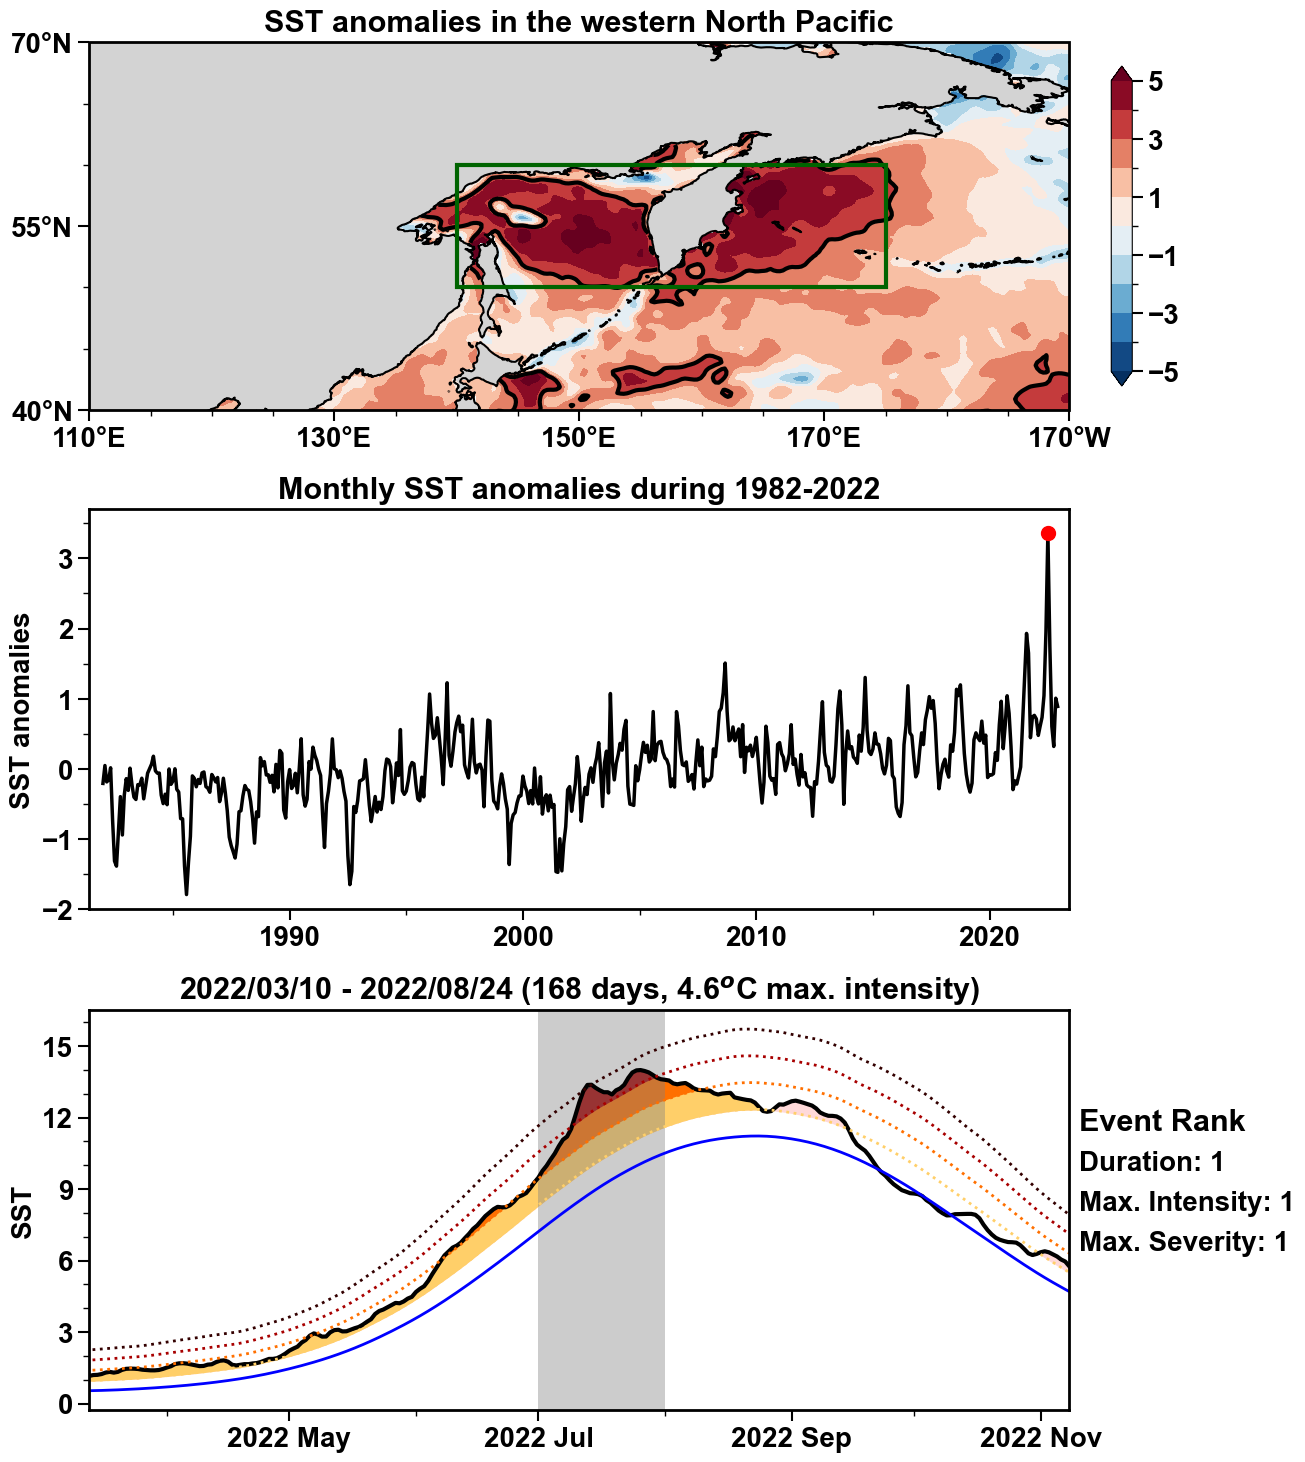

In [6]:
# create event list for plotting
if reg_code == 'os':
    ev_list=[68]

# list of years of target events
ev_yrs=[mhws['date_peak'][x].year for x in ev_list]

# create figure
plt.rcParams.update({'font.size': 20})
plt.rcParams["font.family"] = "Arial"
plt.rc('axes', titleweight='bold')

fig= plt.figure(figsize=(14,16))
proj = ccrs.PlateCarree(central_longitude=140)
ax1 = fig.add_axes([0.1,0.65,0.7,0.3], projection=proj)
leftlon, rightlon, lowerlat, upperlat = (110,190,40,70)
img_extent = [leftlon, rightlon, lowerlat, upperlat]
ax1.set_extent(img_extent, crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND.with_scale('10m'),color='lightgray') 
ax1.add_feature(cfeature.COASTLINE.with_scale('10m'),linewidth=1.5) 
ax1.set_xticks(np.arange(leftlon,rightlon+20,20), crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(lowerlat,upperlat+15,15), crs=ccrs.PlateCarree())
ax1.tick_params(direction='out', length=8, width=1.5, labelsize=20)
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax1.minorticks_on()
ax1.tick_params(which='minor', direction='out', bottom=True, length=4, width=1)
ax1.xaxis.set_minor_locator(plt.MultipleLocator(5))
ax1.yaxis.set_minor_locator(plt.MultipleLocator(5))
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.set_title("SST anomalies in the western North Pacific",fontsize=22,weight='bold',loc='center',pad=8)
ax = plt.gca()
ax.spines['geo'].set_linewidth(2)
ax1.add_patch(patches.Rectangle([0,50],35,10,linewidth=3,edgecolor='darkgreen',facecolor='none',zorder=100))
ax1.contour(lon,lat,sst_ano,[3],colors='k',linewidths=3,transform=ccrs.PlateCarree())
cf1 = ax1.contourf(lon,lat,sst_ano, zorder=0, levels =np.arange(-5,6,1) , extend = 'both',transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r)
pos = fig.add_axes([0.83,0.7,0.015,0.2])
cb = fig.colorbar(cf1,orientation='vertical',cax=pos)
cb.ax.tick_params(labelsize=20)
cb.ax.set_yticks([-5,-3,-1,1,3,5])
cb.ax.minorticks_on()
cb.ax.tick_params(which='minor', direction='out', bottom=True, length=4, width=1)
cb.ax.tick_params(which='major', direction='out', bottom=True, length=8, width=1.5)
cb.ax.yaxis.set_minor_locator(plt.MultipleLocator(1))

# ax = fig.add_axes([0.1,0.06,0.7,0.25])
ax = fig.add_axes([0.1,0.373,0.7,0.25])
date_min = np.datetime64('1981-06')
date_max = np.datetime64('2023-06')
ax.set_xlim(date_min,date_max)
ax.set_ylim(-2,3.7)
ax.plot(datetime_array,sst_oswbs_ano,c='k',lw=2.5)
ax.scatter(datetime_array[-6],sst_oswbs_ano[-6],marker='o',s=100,zorder=10,c='r')
ax.set_ylabel(r'SST anomalies')

ax.tick_params(direction='out', length=8, width=1.5, labelsize=20)
ax.tick_params(which='minor', direction='out', bottom=True, length=4, width=1)
ax.xaxis.set_major_locator(dt.YearLocator(base=10))
ax.xaxis.set_major_formatter(dt.DateFormatter("%Y"))
ax.xaxis.set_minor_locator(dt.YearLocator(base=5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))

# plot other subplot labels

t_str = 'Monthly SST anomalies during 1982-2022'
ax.set_title(t_str,fontname="Arial",loc='center',fontsize=22,pad=8)
# legend header
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)

# plot individual MHW events
# ax = fig.add_axes([0.1,0.373,0.7,0.25])
ax = fig.add_axes([0.1,0.06,0.7,0.25])
nn = 0
ev = ev_list[nn]
# set time-spans and thresholds
t1 = np.where(t==mhws['time_start'][ev])[0][0]
t2 = np.where(t==mhws['time_end'][ev])[0][0]
x0 = dates[t1:t2+1]
y0 = sst[t1:t2+1]
y1 = thresh_cat1[t1:t2+1]
y2 = thresh_cat2[t1:t2+1]
y3 = thresh_cat3[t1:t2+1]
y4 = thresh_cat4[t1:t2+1]
ax.set_yticks([0,3,6,9,12,15])
# Find indices for all ten MHWs before and after event of interest and shade accordingly
emin = ev-10
emax = ev+10
if emax > mhws['n_events']:
    emax = mhws['n_events']

for ev0 in np.arange(emin, emax, 1):
    t1 = np.where(t==mhws['time_start'][ev0])[0][0]
    t2 = np.where(t==mhws['time_end'][ev0])[0][0]
    ax.fill_between(dates[t1:t2+1], sst[t1:t2+1], clim['thresh'][t1:t2+1], \
                        color=(1,0.85,0.85))

# shade main event according to category
ax.fill_between(x0, y0, y1, where = (y1 <= y0), color=[1, 0.81, 0.41], interpolate=True)
ax.fill_between(x0, y0, y2, where = (y2 <= y0), color=[1, 0.44, 0], interpolate=True)
ax.fill_between(x0, y0, y3, where = (y3 <= y0), color=[0.66, 0, 0], interpolate=True)
ax.fill_between(x0, y0, y4, where = (y4 <= y0), color=[0.2, 0, 0], interpolate=True)

# Plot SST, seasonal cycle, threshold, shade MHWs with main event in red
ax.plot(dates, sst, 'k-', linewidth=3)
ax.plot(dates, clim['thresh'], ':', color=[1, 0.81, 0.41], linewidth=2)
ax.plot(dates, thresh_cat2, ':', color=[1, 0.44, 0], linewidth=2)
ax.plot(dates, thresh_cat3, ':', color=[0.66, 0, 0], linewidth=2)
ax.plot(dates, thresh_cat4, ':', color=[0.2, 0, 0], linewidth=2)
ax.plot(dates, clim['seas'], 'b-', linewidth=2)

# other plot parameters
t_centre = mhws['date_start'][ev] + (mhws['date_end'][ev] - mhws['date_start'][ev]) / 2
t_min = t_centre - timedelta(days=80)
t_max = t_centre + timedelta(days=160)
ax.set_xlim(t_min, t_max)
ax.set_ylim(clim['seas'].min()-0.8, thresh_cat4.max()+0.8)
# ax.set_ylabel(r'SST ($^o$C)')
ax.set_ylabel(r'SST')

ax.tick_params(direction='out', length=8, width=1.5, labelsize=20)
ax.tick_params(which='minor', direction='out', bottom=True, length=4, width=1)
ax.xaxis.set_major_locator(dt.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(dt.DateFormatter("%Y %b"))
ax.xaxis.set_minor_locator(dt.MonthLocator(interval=1))
ax.xaxis.set_minor_formatter(ticker.NullFormatter())
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.axvspan(datetime.date(2022, 7, 1), datetime.date(2022, 8, 1), facecolor='gray', alpha=0.4)

# plot title
t_str = mhws['date_start'][ev].strftime("%Y/%m/%d") + ' - ' + \
        mhws['date_end'][ev].strftime("%Y/%m/%d" + ' (' + str(mhws['duration'][ev]) + ' days, ' + \
        "{:.1f}".format(mhws['intensity_max'][ev]) + '$^o$C max. intensity)')
ax.set_title(t_str,fontname="Arial",loc='center',fontsize=22,pad=8)

# Text about ranking
ax.text(1.01, 0.7, 'Event Rank', fontsize=22, fontname="Arial", fontweight="bold", transform=ax.transAxes)
ax.text(1.01, 0.6, 'Duration: ' + str(rank['duration'][ev]), fontsize=20, transform=ax.transAxes)
ax.text(1.01, 0.5, 'Max. Intensity: ' + str(rank['intensity_max'][ev]), fontsize=20, transform=ax.transAxes)
ax.text(1.01, 0.4, 'Max. Severity: ' + str(rank['intensity_max_norm'][ev]), fontsize=20, transform=ax.transAxes)
ax.tick_params(axis='both', which='major', labelsize=20)
ax = plt.gca()
# 设置地图边框粗细
for spine in ax.spines.values():
    spine.set_linewidth(2)

# Save the plot by calling plt.savefig() BEFORE plt.show()
outfile = '/public/home/songqh/project/NC_figure/figures/' + 'figure-1_response' 
# plt.savefig(outfile + '.tiff', facecolor=fig.get_facecolor(), edgecolor='none',dpi=600)
# plt.savefig(outfile + '.jpg', facecolor=fig.get_facecolor(), edgecolor='none',dpi=600)
plt.show()
